### This file will use the Rotational Forest Classifier from the Aeon library

In [1]:
from _Data_Processing import *

'''
this function returns 7 objects:
	data: sets of data as X_train, X_val, X_ind, y_train, y_val, y_ind
	feature_list: list of all feature names with a column index (dict)
'''
X_train, X_val, X_ind,\
y_train, y_val, y_ind,\
feature_subsets =\
preprocess_data(
	file_name   =		'betaset_tmp.csv'
	,indp_size  =		0.01
	,test_size  =		0.20
	,shfl_splt	=		False
	,t_start    =		570
	,t_end		=		720
	,mod_type	=		'Classification'
	,target_t	=		15
	,num_class	=		2
	,split_val	=		5
	,verbose	=		1
	,scaler		=		'Standard'
	,frmt_lstm	=		False
	,time_steps =		5
	,keep_price =		False
)

Trying to load CSV file into DataFrame...Success.
Trying to drop unused targets...Success.
Trying to collect indices of wanted times...Success.
Trying to drop price features...Success...

# of Samples:	226576

# of Features:	436

Target:		tc_2c_15m

Trying to split DataFrame into X and y...Success.
Trying to collect all feature names and indices...Success.
Trying to clean up...Success.
Trying to encode y and make class weights...Failed [NON-FATAL: NOT IMPLEMENTED]
Trying to standardize all featurespace from training featurespace...Success.
Trying to drop unwanted time-range samples...Success.
	201633 Samples Dropped.

Trying to split X and y into Train/Validation/Independent...Success.
Trying to clean up...Success.
X_train:	(19704, 436).
y_train:	(19704,).
X_val:  	(4989, 436).
y_val:  	(4989,).
X_ind:  	(250, 436).
y_ind:  	(250,).
Terminating.


In [2]:
from _Data_Rotating import *

'''
This function returns 4 items.
-	2D array of X partitions, by featurespace and samplespace
-	1D array of index-lists for each featurespace-partition specific features
-	1D array of featurespace-partition specific rotation transformer functions
-	1D array of y partitions for each samplespace partition.
'''

X_train_parts, X_find_parts, X_trans_parts, y_parts = rotate_partitions(
	X				=	X_train
    ,y				=	y_train
	,n_feat_parts	=	16
	,feat_subsets	=	feature_subsets
	,feat_part_type	=	'by_subset'
	,fraction_feats	=	0.75
	,no_feat_overlap=	False
	,feats_for_all	=	[]
	,rotation_type	=	'None'
	,rotation_filter=	False
	,filter_type	=	'Retention'
	,filter_value	=	1.0
    ,n_sample_parts	=	1
    ,smpl_part_type	=	'Even'
    ,sample_shuffle	=	False
)

'''
all partitions
	X_train_parts
all sample partitions of THE featurespace partition i
	X_train_parts[i]
The single partition of THE samplespace partition j of THE featurespace partition i
	X_train_parts[i][j] -- -- -- This is now a set of trainable data
'''

'\nall partitions\n\tX_train_parts\nall sample partitions of THE featurespace partition i\n\tX_train_parts[i]\nThe single partition of THE samplespace partition j of THE featurespace partition i\n\tX_train_parts[i][j] -- -- -- This is now a set of trainable data\n'

In [13]:
from _Modelset_Training import *

show_available_model_types()

	   'decision_tree'
	   'dt'
		-	-	Sci-Kit Learn DecisionTreeClassifier
		-	-	{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1}
	   
	   'rotation_forest'
	   'aeon_rf'
		   -	-	AEON Rotation Forest
		-	-	{'base_estimator': DecisionTreeClassifier(max_depth=4), 'n_estimators': 4, 'min_group': 1, 'max_group': 20, 'remove_proportion': 0.3, 'n_jobs': -1}
	   
	   


In [3]:
from _Modelset_Training import *

'''
Function returns a 3D list of trained models that are fit to the resepective dataset.
	Dim1:	Featurespace, here are the subsetctions/partitions for each unique set of features
    Dim2:	Samplespace, here are the subsetctions/partitions for each unique set of samples
    Dim3:	Modelspace, here are the individual models trained on a unique partition
'''

models = train_models(
    model_types=['aeon_rf']
    ,data_parts=X_train_parts
    ,trgt_parts=y_parts
    ,param_mode='default'
    ,cst_mod_prm=None
    ,tnr_verbose=True
)

Default parameters selected.
aeon_rf	-	{'base_estimator': DecisionTreeClassifier(max_depth=4), 'n_estimators': 4, 'min_group': 1, 'max_group': 20, 'remove_proportion': 0.3, 'n_jobs': -1}


In [4]:
from _Model_Evaluation import *

evaluate_models(
		models=models
		,X_findx=X_find_parts
		,X_trans=X_trans_parts
		,X_train=X_train_parts
		,y_train=y_parts
		,X_test=X_val
		,y_test=y_val
		,prfm_gnrl	=	'all'
		,prfm_stat	=	'all'
		,disp_mthd	=	'as_value'
		,test_whch	=	'independent'
		,pred_type	=	'classification'
)

Dimensions of Trained Models:
	Feature Space: 16
	Sample Space: 1
	Model Space: 1


	Displaying all performances for all independent samples: (16 cases)

4

Statistics Overall:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.53	0.02	0.5	0.56
		Precision	0.56	0.02	0.53	0.6
		Recall		0.56	0.12	0.32	0.8

Statistics By Feature Space:

	Split 0:
				Avg	St.Dv.	Low	High
		Accuracy	0.56	0.0	0.56	0.56
		Precision	0.57	0.0	0.57	0.57
		Recall		0.65	0.0	0.65	0.65
	Split 1:
				Avg	St.Dv.	Low	High
		Accuracy	0.52	0.0	0.52	0.52
		Precision	0.56	0.0	0.56	0.56
		Recall		0.5	0.0	0.5	0.5
	Split 2:
				Avg	St.Dv.	Low	High
		Accuracy	0.54	0.0	0.54	0.54
		Precision	0.56	0.0	0.56	0.56
		Recall		0.59	0.0	0.59	0.59
	Split 3:
				Avg	St.Dv.	Low	High
		Accuracy	0.5	0.0	0.5	0.5
		Precision	0.55	0.0	0.55	0.55
		Recall		0.32	0.0	0.32	0.32
	Split 4:
				Avg	St.Dv.	Low	High
		Accuracy	0.51	0.0	0.51	0.51
		Precision	0.55	0.0	0.55	0.55
		Recall		0.47	0.0	0.47	0.47
	Split 5:
				Avg	St.Dv.	Low	High
		Accuracy	0.53	0.0

In [ ]:
from _Prediction_Fusion import *

y_pred = pred_proba_fusion(
	models=models
	,type_model=type(models[0])
	,X_test=X_val
	,fusion_type='Popular'
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from aeon.classification.sklearn import RotationForestClassifier

def new_dt(max_depth):
    return DecisionTreeClassifier(max_depth=max_depth)

#56%accuracy with these stats
model = RotationForestClassifier(base_estimator=new_dt(max_depth=4),
                                    n_estimators=4
                                    ,min_group=1
                                    ,max_group=20
                                    ,remove_proportion= 0.3
                                    ,contract_max_n_estimators=500
                                    ,random_state=42,n_jobs=-1)


META-MODEL INDEPENDENT TEST:
	Accuracy:	0.54
	Precision:	0.57
	Recall:	0.58


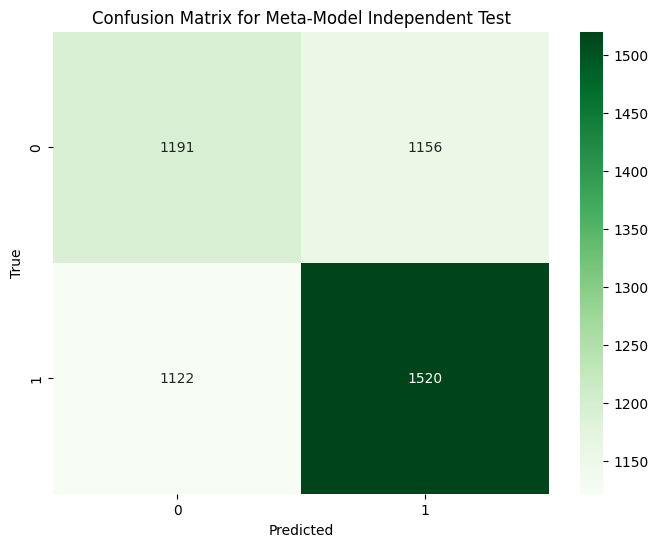

In [19]:
import _Metamodel
from importlib import reload

reload(_Metamodel)
_Metamodel.train_test_meta_model(
	models	=	models
	,X_findx=X_find_parts
	,X_trans=X_trans_parts
	,X_test	=	X_val
	,y_test	=	y_val
	,val_size	=	0.2
	,shuffle	=	False
	,metam_type = 'popular_vote'
)